<a href="https://colab.research.google.com/github/minoxd/fiber_optic_box_inspection/blob/main/yolo_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
print(Path('/content/drive/MyDrive/fiber_optic_box_inspection/dataset_v2_ALL/processed_dataset.tar.gz').exists())
!ls /content/drive/MyDrive/fiber_optic_box_inspection/dataset_v2_ALL

True
all_P00.txt			     test_P35.txt
all_P25.txt			     test_P40.txt
all_P30.txt			     train_P00.txt
all_P35.txt			     train_P25.txt
all_P40.txt			     train_P30.txt
class_names_P00.txt		     train_P35.txt
class_names_P25.txt		     train_P40_aug_1.txt
class_names_P30.txt		     train_P40_aug_2.txt
class_names_P35.txt		     train_P40_aug_3.txt
class_names_P40.txt		     train_P40_aug_4.txt
ids_from_label_files_backup_dir.txt  train_P40.txt
investigate_all_P00.csv		     val_P00.txt
investigate_all_P25.csv		     val_P25.txt
investigate_all_P30.csv		     val_P30.txt
investigate_all_P35.csv		     val_P35.txt
investigate_all_P40.csv		     val_P40.txt
processed_dataset.tar.gz	     yolo_data_cfg_P00.yaml
split_P00.csv			     yolo_data_cfg_P25.yaml
split_P25.csv			     yolo_data_cfg_P30.yaml
split_P30.csv			     yolo_data_cfg_P35.yaml
split_P35.csv			     yolo_data_cfg_P40_aug_1.yaml
split_P40.csv			     yolo_data_cfg_P40_aug_2.yaml
test_P00.txt			     yolo_data_cfg_P40_aug_3.yaml
test_P25.txt	

# Environmental Setup

## mount gdrive, import libraries, declare constants, specify paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path
import shutil
import tarfile
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if Path('/content/sample_data').exists():
    shutil.rmtree('/content/sample_data')

In [ ]:
IMGSZ = 960

These files are required in the `Data_INF` folder:
- data_label_All.tar.gz
- inf_raw_classes_v1.0.json
- matching_name_id_v1.0.xlsx

In [ ]:
BASE_DIR = '/content/drive/MyDrive/fiber_optic_box_inspection'
if not Path(BASE_DIR).exists():
    raise FileNotFoundError(f'Base directory {BASE_DIR} not found. Check Google Drive mount.')

LOCAL_BASE_DIR = '/content'

paths = {
    'base_dir':                                   Path(BASE_DIR),
    'dataset_dir':                                Path(BASE_DIR, 'dataset_v2_ALL'),
    'yolo_output_dir':                            Path(BASE_DIR, 'runs_yolo'),
}

paths['processed_dataset_compressed'] =           Path(paths['dataset_dir'], 'processed_dataset.tar.gz')

local_paths = {
    'base_dir':                                   Path(LOCAL_BASE_DIR),
    'dataset_dir':                                Path(LOCAL_BASE_DIR, 'dataset_v2_ALL'),
}

if not local_paths['dataset_dir'].exists():
    Path.mkdir(local_paths['dataset_dir'])

local_paths['yolo_data_cfg_P00'] =                Path(local_paths['dataset_dir'], 'yolo_data_cfg_P00.yaml')
local_paths['yolo_data_cfg_P25'] =                Path(local_paths['dataset_dir'], 'yolo_data_cfg_P25.yaml')
local_paths['yolo_data_cfg_P30'] =                Path(local_paths['dataset_dir'], 'yolo_data_cfg_P30.yaml')
local_paths['yolo_data_cfg_P35'] =                Path(local_paths['dataset_dir'], 'yolo_data_cfg_P35.yaml')
local_paths['yolo_data_cfg_P40'] =                Path(local_paths['dataset_dir'], 'yolo_data_cfg_P40.yaml')

local_paths['yolo_data_cfg_P40_aug_1'] =          Path(local_paths['dataset_dir'], 'yolo_data_cfg_P40_aug_1.yaml')
local_paths['yolo_data_cfg_P40_aug_2'] =          Path(local_paths['dataset_dir'], 'yolo_data_cfg_P40_aug_2.yaml')

## utils

In [ ]:
class Run():
    def __init__(self, run_name, project):
        self.train_run_name = f'train_{run_name}'
        self.val_run_name = f'val_{run_name}'
        self.train_path = Path(project, self.train_run_name)
        self.val_path = Path(project, self.val_run_name)
        self.__best_weight_path = Path(self.train_path, 'weights', 'best.pt')
        self.__last_weight_path = Path(self.train_path, 'weights', 'last.pt')

    def get_best_weight_path(self):
        if self.train_path.is_dir():
            return self.__best_weight_path
        else:
            raise FileNotFoundError(f'The run {self.train_run_name} does not exist.')

    def get_last_weight_path(self):
        if self.train_path.is_dir():
            return self.__last_weight_path
        else:
            raise FileNotFoundError(f'The run {self.train_run_name} does not exist.')

# Get dataset

In [ ]:
!rm -rf /content/dataset_v2_ALL/

In [ ]:
shutil.copytree(paths['dataset_dir'], local_paths['dataset_dir'], dirs_exist_ok=True)

PosixPath('/content/dataset_v2_ALL')

In [ ]:
with tarfile.open(paths['processed_dataset_compressed'], 'r:gz') as tar_file:
    tar_file.extractall(local_paths['dataset_dir'])
    print(f"Extracted {paths['processed_dataset_compressed']} to {local_paths['dataset_dir']}")

Extracted /content/drive/MyDrive/fiber_optic_box_inspection/dataset_v2_ALL/processed_dataset.tar.gz to /content/dataset_v2_ALL


# install ultralytics

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# define runs

In [ ]:
yolo_default_augmentations_P00 = Run('default_augmentations_P00_', paths['yolo_output_dir'])
yolo_default_augmentations_P25 = Run('default_augmentations_P25_', paths['yolo_output_dir'])
yolo_default_augmentations_P30 = Run('default_augmentations_P30_', paths['yolo_output_dir'])
yolo_default_augmentations_P35 = Run('default_augmentations_P35_', paths['yolo_output_dir'])
yolo_default_augmentations_P40 = Run('default_augmentations_P40_', paths['yolo_output_dir'])
yolo_no_augmentations_P40 = Run('no_augmentations_P40_', paths['yolo_output_dir'])
yolo_aug_1_P40 = Run('aug_1_P40_', paths['yolo_output_dir'])
yolo_aug_2_P40 = Run('aug_2_P40_', paths['yolo_output_dir'])
yolo_aug_3_P40 = Run('aug_3_P40_', paths['yolo_output_dir'])
yolo_aug_4_P40 = Run('aug_4_P40_', paths['yolo_output_dir'])

# GPU check

In [ ]:
!nvidia-smi

Thu Jul  3 16:48:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU is available! Using device: {device}')
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    print(f'Number of GPUs: {torch.cuda.device_count()}')
    print(f'Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
else:
    device = torch.device('cpu')
    print('No GPU available, using CPU.')


GPU is available! Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB
Number of GPUs: 1
Total Memory: 42.47 GB


# runs

## default augmentations

### P00

In [ ]:
model_P00 = YOLO(yolo_default_augmentations_P00.get_best_weight_path()) # todo
metrics_P00 = model_P00.val(
    data=local_paths['yolo_data_cfg_P00'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_default_augmentations_P00.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,939,927 parameters, 0 gradients, 79.2 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 66.0MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2704.9±942.0 MB/s, size: 123.5 KB)



val: Scanning /content/dataset_v2_ALL/image_label_P00... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1380.77it/s]

val: /content/dataset_v2_ALL/image_label_P00/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P00/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P00/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P00/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P00/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P00/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed


val: New cache created: /content/dataset_v2_ALL/image_label_P00.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:52<00:00,  1.71s/it]


                   all       2100      23468      0.721      0.518      0.571      0.382
                   1.0        209        210      0.762      0.919      0.896      0.759
                   1.1         90         90      0.587      0.773      0.704       0.54
                   1.2         41         42      0.434      0.524      0.552      0.404
                   1.7         29         29      0.242      0.724       0.54      0.417
                   2.0        370        371      0.907       0.97      0.978      0.862
                   2.3          1          1          0          0          0          0
                   3.0        356        356       0.93      0.963       0.98      0.667
                   3.1          4          4      0.864        0.5      0.694      0.379
                   5.0        316        616       0.94      0.987      0.987      0.693
                   5.1         17         18      0.765      0.363      0.543      0.306
                   6.

In [ ]:
with open(Path(yolo_default_augmentations_P00.val_path, 'metrics_P00.pkl'), 'wb') as f:
    pickle.dump(metrics_P00, f)

### P25

In [ ]:
model_P25 = YOLO(yolo_default_augmentations_P25.get_best_weight_path()) # todo
metrics_P25 = model_P25.val(
    data=local_paths['yolo_data_cfg_P25'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_default_augmentations_P25.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2498.5±665.7 MB/s, size: 129.8 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P25... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1454.44it/s]

val: /content/dataset_v2_ALL/image_label_P25/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P25/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P25/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P25/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P25/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P25/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset_v2_ALL/image_label_P25.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


                   all       2100      23398      0.678      0.637      0.634      0.427
                   1.0        207        208      0.757      0.904      0.895      0.771
                   1.1         89         89       0.66      0.843      0.764      0.614
                   1.2         41         42      0.453      0.452      0.412       0.27
                   1.7         29         29      0.403      0.552      0.529      0.373
                   2.0        366        367      0.922      0.969      0.971      0.862
                   3.0        351        351      0.909      0.969      0.973      0.668
                   5.0        315        614      0.918      0.987      0.984      0.694
                   5.1         17         18      0.888      0.443      0.539      0.297
                   6.0        318        319      0.916      0.972       0.97      0.755
                   7.0        283        283      0.765      0.968      0.896      0.623
                   7.

In [ ]:
with open(Path(yolo_default_augmentations_P25.val_path, 'metrics_P25.pkl'), 'wb') as f:
    pickle.dump(metrics_P25, f)

### P30

In [ ]:
model_P30 = YOLO(yolo_default_augmentations_P30.get_best_weight_path()) # todo
metrics_P30 = model_P30.val(
    data=local_paths['yolo_data_cfg_P30'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_default_augmentations_P30.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2353.3±680.5 MB/s, size: 123.1 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P30... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1452.79it/s]

val: /content/dataset_v2_ALL/image_label_P30/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P30/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P30/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P30/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P30/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P30/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset_v2_ALL/image_label_P30.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:55<00:00,  1.75s/it]


                   all       2100      23341      0.698      0.676      0.674      0.454
                   1.0        201        203      0.745      0.921      0.891       0.76
                   1.1         89         89      0.675      0.809      0.786      0.622
                   1.2         41         42      0.512      0.525       0.52      0.336
                   1.7         29         29      0.213      0.552      0.484      0.336
                   2.0        361        362      0.889      0.972      0.974      0.861
                   3.0        347        347       0.93      0.965      0.976      0.642
                   5.0        314        612       0.95      0.979      0.987      0.689
                   5.1         17         18       0.76      0.333      0.536      0.289
                   6.0        322        323      0.933      0.972      0.971      0.752
                   7.0        286        286      0.792      0.951      0.883      0.605
                   7.

In [ ]:
with open(Path(yolo_default_augmentations_P30.val_path, 'metrics_P30.pkl'), 'wb') as f:
    pickle.dump(metrics_P30, f)

### P35

In [ ]:
model_P35 = YOLO(yolo_default_augmentations_P35.get_best_weight_path()) # todo
metrics_P35 = model_P35.val(
    data=local_paths['yolo_data_cfg_P35'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_default_augmentations_P35.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2571.1±685.9 MB/s, size: 134.0 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P35... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1459.26it/s]

val: /content/dataset_v2_ALL/image_label_P35/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P35/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P35/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P35/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P35/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P35/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset_v2_ALL/image_label_P35.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


                   all       2100      23291      0.665      0.709      0.694       0.47
                   1.0        201        203      0.723      0.936       0.91      0.782
                   1.1         89         89      0.576      0.749      0.727       0.57
                   1.2         41         42      0.336      0.524      0.464      0.336
                   1.7         29         29      0.527        0.5      0.518      0.395
                   2.0        361        362      0.875      0.975      0.972      0.859
                   3.0        347        347      0.918      0.968      0.975      0.653
                   5.0        314        612      0.947      0.986      0.985      0.678
                   6.0        322        323      0.941      0.969       0.97      0.749
                   7.0        286        286      0.816       0.93      0.892      0.623
                   7.1         16         16     0.0597     0.0625      0.104     0.0612
                   8.

In [ ]:
with open(Path(yolo_default_augmentations_P35.val_path, 'metrics_P35.pkl'), 'wb') as f:
    pickle.dump(metrics_P35, f)

### P40

In [ ]:
model_P40 = YOLO(yolo_default_augmentations_P40.get_best_weight_path()) # todo
metrics_P40 = model_P40.val(
    data=local_paths['yolo_data_cfg_P40'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_default_augmentations_P40.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2284.0±832.3 MB/s, size: 111.5 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P40... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1415.43it/s]

val: /content/dataset_v2_ALL/image_label_P40/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset_v2_ALL/image_label_P40.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:54<00:00,  1.74s/it]


                   all       2100      23204      0.684      0.739      0.728      0.496
                   1.0        197        199      0.723       0.92      0.889      0.751
                   1.1         89         89       0.59      0.809        0.7      0.555
                   1.2         41         42      0.481      0.375      0.482      0.357
                   1.7         30         30      0.583      0.533      0.567      0.399
                   2.0        358        359       0.86      0.986      0.972      0.856
                   3.0        344        344      0.917      0.957      0.975      0.651
                   5.0        313        610      0.942      0.992      0.983      0.679
                   6.0        320        321      0.951      0.969      0.974      0.736
                   7.0        285        285      0.799      0.947      0.883      0.602
                   8.0        298        847        0.8      0.836       0.84      0.502
                   8.

In [ ]:
with open(Path(yolo_default_augmentations_P40.val_path, 'metrics_P40.pkl'), 'wb') as f:
    pickle.dump(metrics_P40, f)

## no augmentations

### P40

In [ ]:
model_P40 = YOLO(yolo_no_augmentations_P40.get_best_weight_path()) # todo
metrics_P40 = model_P40.val(
    data=local_paths['yolo_data_cfg_P40'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_no_augmentations_P40.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2113.9±582.4 MB/s, size: 124.3 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P40.cache... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<?, ?it/s]

val: /content/dataset_v2_ALL/image_label_P40/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:34<00:00,  1.43s/it]


                   all       2100      23204      0.661      0.703      0.683      0.457
                   1.0        197        199      0.707      0.837      0.827      0.693
                   1.1         89         89      0.397      0.865       0.63      0.494
                   1.2         41         42      0.387      0.476      0.376      0.199
                   1.7         30         30      0.404      0.467      0.514      0.382
                   2.0        358        359       0.89      0.967      0.957      0.842
                   3.0        344        344      0.945      0.936      0.956      0.646
                   5.0        313        610      0.924      0.964      0.971      0.674
                   6.0        320        321      0.926      0.973      0.968       0.73
                   7.0        285        285      0.828      0.891      0.883      0.602
                   8.0        298        847      0.726      0.834      0.822      0.471
                   8.

In [ ]:
with open(Path(yolo_no_augmentations_P40.val_path, 'metrics_P40.pkl'), 'wb') as f:
    pickle.dump(metrics_P40, f)

## aug 1

In [ ]:
model_P40_aug_1 = YOLO(yolo_aug_1_P40.get_best_weight_path()) # todo
metrics_P40_aug_1 = model_P40_aug_1.val(
    data=local_paths['yolo_data_cfg_P40_aug_1'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_aug_1_P40.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3094.0±530.6 MB/s, size: 125.6 KB)



val: Scanning /content/dataset_v2_ALL/image_label_P40... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1448.79it/s]

val: /content/dataset_v2_ALL/image_label_P40/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset_v2_ALL/image_label_P40.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [02:36<00:00,  2.37s/it]


                   all       2100      23204        0.7      0.667      0.663      0.436
                   1.0        197        199      0.734      0.884      0.854      0.708
                   1.1         89         89      0.742      0.348       0.58      0.445
                   1.2         41         42      0.639      0.429      0.484       0.28
                   1.7         30         30      0.205     0.0667      0.139     0.0803
                   2.0        358        359      0.949      0.888      0.955      0.821
                   3.0        344        344       0.94      0.916      0.956      0.624
                   5.0        313        610      0.878       0.97      0.964       0.64
                   6.0        320        321      0.894      0.972      0.948      0.677
                   7.0        285        285      0.798      0.861      0.856      0.547
                   8.0        298        847      0.643      0.848       0.79      0.451
                   8.

In [ ]:
with open(Path(yolo_aug_1_P40.val_path, 'metrics_P40_aug_1.pkl'), 'wb') as f:
    pickle.dump(metrics_P40_aug_1, f)

## aug 2

In [ ]:
model_P40_aug_2 = YOLO(yolo_aug_2_P40.get_best_weight_path()) # todo
metrics_P40_aug_2 = model_P40_aug_2.val(
    data=local_paths['yolo_data_cfg_P40_aug_2'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_aug_2_P40.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 64.4±21.1 MB/s, size: 125.7 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P40.cache... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<?, ?it/s]

val: /content/dataset_v2_ALL/image_label_P40/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:05<00:00,  1.01it/s]


                   all       2100      23204      0.785      0.779        0.8      0.603
                   1.0        197        199      0.766      0.886      0.859      0.735
                   1.1         89         89      0.706      0.673      0.709      0.558
                   1.2         41         42      0.431      0.361      0.365       0.24
                   1.7         30         30       0.26      0.367      0.363      0.276
                   2.0        358        359       0.92       0.95      0.962      0.844
                   3.0        344        344      0.917      0.942      0.948      0.629
                   5.0        313        610      0.945      0.959      0.974       0.69
                   6.0        320        321      0.943      0.973      0.965      0.758
                   7.0        285        285      0.845      0.902      0.904      0.642
                   8.0        298        847      0.814      0.779      0.818      0.497
                   8.

In [ ]:
with open(Path(yolo_aug_2_P40.val_path, 'metrics_P40_aug_2.pkl'), 'wb') as f:
    pickle.dump(metrics_P40_aug_2, f)

## aug 3

In [ ]:
model_P40_aug_3 = YOLO(yolo_aug_3_P40.get_best_weight_path()) # todo
metrics_P40_aug_3 = model_P40_aug_3.val(
    data=local_paths['yolo_data_cfg_P40_aug_3'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_aug_3_P40.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 49.3±10.6 MB/s, size: 122.5 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P40.cache... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<?, ?it/s]

val: /content/dataset_v2_ALL/image_label_P40/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:09<00:00,  1.05s/it]


                   all       2100      23204      0.809      0.775      0.803       0.61
                   1.0        197        199      0.787      0.879      0.871      0.744
                   1.1         89         89      0.684      0.658      0.633      0.489
                   1.2         41         42      0.572      0.381      0.461      0.323
                   1.7         30         30      0.335      0.386      0.334      0.218
                   2.0        358        359      0.926      0.944      0.953      0.843
                   3.0        344        344      0.925      0.942       0.93       0.62
                   5.0        313        610      0.956      0.952      0.968      0.697
                   6.0        320        321      0.941      0.972      0.957      0.746
                   7.0        285        285      0.851      0.898      0.895      0.629
                   8.0        298        847      0.838      0.743      0.813      0.511
                   8.

In [ ]:
with open(Path(yolo_aug_3_P40.val_path, 'metrics_P40_aug_3.pkl'), 'wb') as f:
    pickle.dump(metrics_P40_aug_3, f)

## aug 4

In [ ]:
model_P40_aug_4 = YOLO(yolo_aug_4_P40.get_best_weight_path()) # todo
metrics_P40_aug_4 = model_P40_aug_4.val(
    data=local_paths['yolo_data_cfg_P40_aug_4'],
    batch=32,
    imgsz=IMGSZ,
    save_json=True,
    device=0,
    plots=True,
    project=paths['yolo_output_dir'],
    name=yolo_aug_4_P40.val_run_name, #todo
    verbose=True,
    save_txt=True,
    save_conf=True,
    workers=16,
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,938,190 parameters, 0 gradients, 79.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 34.0±2.5 MB/s, size: 108.5 KB)


val: Scanning /content/dataset_v2_ALL/image_label_P40.cache... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<?, ?it/s]

val: /content/dataset_v2_ALL/image_label_P40/2022_11_14_16_04_38-HNIP548102HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_10_35_33-GLIP038152HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_16_15_40_51-HBHP012080HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_17_15_10_14-TNNP063261HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_11_21_09_08_32-TNNP069058HO.jpg: 1 duplicate labels removed
val: /content/dataset_v2_ALL/image_label_P40/2022_12_08_10_14_33-HYNP074125HO.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:17<00:00,  1.18s/it]


                   all       2100      23204      0.823      0.799      0.827      0.625
                   1.0        197        199        0.8      0.904      0.883      0.751
                   1.1         89         89      0.683      0.652      0.721      0.567
                   1.2         41         42      0.515        0.5      0.515      0.373
                   1.7         30         30      0.379        0.4      0.375      0.265
                   2.0        358        359      0.915      0.958      0.943      0.827
                   3.0        344        344      0.914      0.942      0.943      0.635
                   5.0        313        610      0.946      0.966      0.965      0.664
                   6.0        320        321      0.949      0.963      0.955      0.766
                   7.0        285        285      0.857      0.906      0.912      0.637
                   8.0        298        847      0.837      0.772      0.804      0.479
                   8.

In [ ]:
with open(Path(yolo_aug_4_P40.val_path, 'metrics_P40_aug_4.pkl'), 'wb') as f:
    pickle.dump(metrics_P40_aug_4, f)

# test

In [ ]:
with open(Path(yolo_default_augmentations_P00.val_path, 'metrics_P00.pkl'), 'rb') as f:
    metrics_P00 = pickle.load(f)
with open(Path(yolo_default_augmentations_P25.val_path, 'metrics_P25.pkl'), 'rb') as f:
    metrics_P25 = pickle.load(f)
with open(Path(yolo_default_augmentations_P30.val_path, 'metrics_P30.pkl'), 'rb') as f:
    metrics_P30 = pickle.load(f)
with open(Path(yolo_default_augmentations_P35.val_path, 'metrics_P35.pkl'), 'rb') as f:
    metrics_P35 = pickle.load(f)
with open(Path(yolo_default_augmentations_P40.val_path, 'metrics_P40.pkl'), 'rb') as f:
    metrics_P40 = pickle.load(f)
with open(Path(yolo_no_augmentations_P40.val_path, 'metrics_P40.pkl'), 'rb') as f:
    metrics_P40_aug_none = pickle.load(f)
with open(Path(yolo_aug_1_P40.val_path, 'metrics_P40_aug_1.pkl'), 'rb') as f:
    metrics_P40_aug_1 = pickle.load(f)
with open(Path(yolo_aug_2_P40.val_path, 'metrics_P40_aug_2.pkl'), 'rb') as f:
    metrics_P40_aug_2 = pickle.load(f)
with open(Path(yolo_aug_3_P40.val_path, 'metrics_P40_aug_3.pkl'), 'rb') as f:
    metrics_P40_aug_3 = pickle.load(f)
with open(Path(yolo_aug_4_P40.val_path, 'metrics_P40_aug_4.pkl'), 'rb') as f:
    metrics_P40_aug_4 = pickle.load(f)

In [ ]:
df_metrics_P00 = metrics_P00.to_df()
df_metrics_P00 = df_metrics_P00.set_index('Class')
df_metrics_P25 = metrics_P25.to_df()
df_metrics_P25 = df_metrics_P25.set_index('Class')
df_metrics_P30 = metrics_P30.to_df()
df_metrics_P30 = df_metrics_P30.set_index('Class')
df_metrics_P35 = metrics_P35.to_df()
df_metrics_P35 = df_metrics_P35.set_index('Class')
df_metrics_P40 = metrics_P40.to_df()
df_metrics_P40 = df_metrics_P40.set_index('Class')
df_metrics_P40_aug_none = metrics_P40_aug_none.to_df()
df_metrics_P40_aug_none = df_metrics_P40_aug_none.set_index('Class')
df_metrics_P40_aug_1 = metrics_P40_aug_1.to_df()
df_metrics_P40_aug_1 = df_metrics_P40_aug_1.set_index('Class')
df_metrics_P40_aug_2 = metrics_P40_aug_2.to_df()
df_metrics_P40_aug_2 = df_metrics_P40_aug_2.set_index('Class')
df_metrics_P40_aug_3 = metrics_P40_aug_3.to_df()
df_metrics_P40_aug_3 = df_metrics_P40_aug_3.set_index('Class')
df_metrics_P40_aug_4 = metrics_P40_aug_4.to_df()
df_metrics_P40_aug_4 = df_metrics_P40_aug_4.set_index('Class')

In [ ]:
df_mean_metrics = pd.concat([
    df_metrics_P00.mean(numeric_only=True),
                                    df_metrics_P25.mean(numeric_only=True),
                                    df_metrics_P30.mean(numeric_only=True),
                                    df_metrics_P35.mean(numeric_only=True),
                                    df_metrics_P40.mean(numeric_only=True),
                             df_metrics_P40_aug_none.mean(numeric_only=True),
                             df_metrics_P40_aug_1.mean(numeric_only=True),
                             df_metrics_P40_aug_2.mean(numeric_only=True),
                             df_metrics_P40_aug_3.mean(numeric_only=True),
                             df_metrics_P40_aug_4.mean(numeric_only=True),
                             ], axis=1)

In [ ]:
df_mean_metrics.transpose().drop(columns=['Images', 'Instances', 'Box-P', 'Box-R'])

,Box-F1,mAP50,mAP50-95
0,0.495289,0.570668,0.382055
1,0.602999,0.633737,0.427420
2,0.646231,0.674154,0.453933
3,0.668216,0.694336,0.470178
4,0.698103,0.728303,0.495579
5,0.667627,0.683368,0.457351
6,0.623589,0.662962,0.436272
7,0.778136,0.799964,0.602906
8,0.786902,0.803384,0.610204
9,0.806832,0.826511,0.624859


In [ ]:
import numpy as np

In [ ]:
df_mean_metrics.to_csv('/content/metrics_data_aug.csv')

Mean Metrics for Class Reduction Runs:
                              Box-F1     mAP50  mAP50-95
Run 1 (Full)                0.495289  0.570668  0.382055
Run 2 (25th)                0.602999  0.633737  0.427420
Run 3 (30th)                0.646231  0.674154  0.453933
Run 4 (35th)                0.668216  0.694336  0.470178
Run 5 (40th)                0.698103  0.728303  0.495579
Run A                       0.667627  0.683368  0.457351
Run B (Resize/Crop)         0.623589  0.662962  0.436272
Run C (Affine/Perspective)  0.778136  0.799964  0.602906
Run D (Sun Flare/Shadow)    0.786902  0.803384  0.610204
Run E (Mosaic)              0.806832  0.826511  0.624859


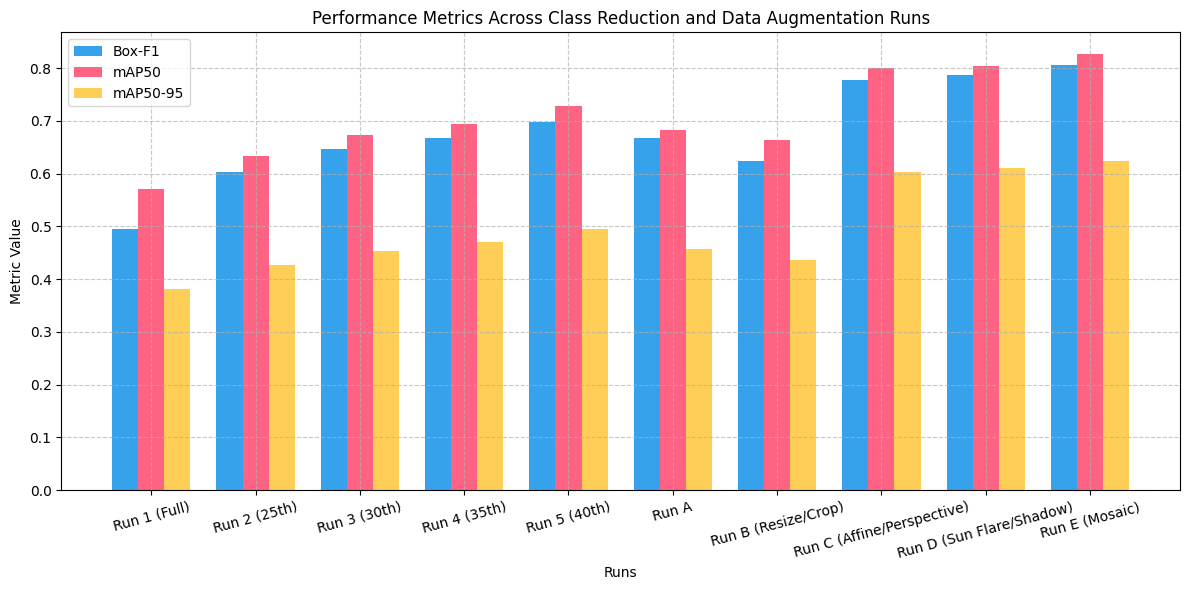

In [ ]:

# Transpose and drop specified columns
df_plot = df_mean_metrics.transpose().drop(columns=['Images', 'Instances', 'Box-P', 'Box-R'])
df_plot.index = ['Run 1 (Full)', 'Run 2 (25th)', 'Run 3 (30th)', 'Run 4 (35th)', 'Run 5 (40th)',
                 'Run A', 'Run B (Resize/Crop)', 'Run C (Affine/Perspective)', 'Run D (Sun Flare/Shadow)', 'Run E (Mosaic)', ]

# Print the resulting DataFrame for verification
print("Mean Metrics for Class Reduction Runs:")
print(df_plot)

# Set up the bar plot
x = np.arange(len(df_plot.index))  # Positions for the runs
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
bar1 = ax.bar(x - width, df_plot['Box-F1'], width, label='Box-F1', color='#36A2EB')
bar2 = ax.bar(x, df_plot['mAP50'], width, label='mAP50', color='#FF6384')
bar3 = ax.bar(x + width, df_plot['mAP50-95'], width, label='mAP50-95', color='#FFCE56')

# Customize the plot
ax.set_xlabel('Runs')
ax.set_ylabel('Metric Value')
ax.set_title('Performance Metrics Across Class Reduction and Data Augmentation Runs')
ax.set_xticks(x)
ax.set_xticklabels(df_plot.index, rotation=15)
ax.legend()

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot (uncomment to save as a file)
# plt.savefig('class_reduction_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
def count(dfa, dfb):
    common_index = dfa.index.intersection(dfb.index)
    s = pd.DataFrame(index=common_index)
    s['Box-F1'] = dfa.loc[common_index, 'Box-F1'] < dfb.loc[common_index, 'Box-F1']
    s['mAP50'] = dfa.loc[common_index, 'mAP50'] < dfb.loc[common_index, 'mAP50']
    s['mAP50-95'] = dfa.loc[common_index, 'mAP50-95'] < dfb.loc[common_index, 'mAP50-95']
    row_sum = s.sum(axis=1)
    ans = []
    for i in range(4):
        ans.append(row_sum[row_sum == i].count())
    print(ans)

In [ ]:
count(df_metrics_P00, df_metrics_P25)
count(df_metrics_P25, df_metrics_P30)
count(df_metrics_P30, df_metrics_P35)
count(df_metrics_P35, df_metrics_P40)
count(df_metrics_P00, df_metrics_P40)

[np.int64(31), np.int64(32), np.int64(21), np.int64(20)]
[np.int64(22), np.int64(21), np.int64(29), np.int64(26)]
[np.int64(17), np.int64(31), np.int64(20), np.int64(24)]
[np.int64(27), np.int64(17), np.int64(20), np.int64(20)]
[np.int64(32), np.int64(16), np.int64(21), np.int64(15)]


In [ ]:
df_metrics_P40.mean(numeric_only=True)

,0
Images,182.571429
Instances,276.238095
Box-P,0.683770
Box-R,0.739141
Box-F1,0.698103
mAP50,0.728303
mAP50-95,0.495579


In [ ]:
df_metrics_P40_aug_none.mean(numeric_only=True)

,0
Images,182.571429
Instances,276.238095
Box-P,0.660607
Box-R,0.703370
Box-F1,0.667627
mAP50,0.683368
mAP50-95,0.457351


In [ ]:
df_metrics_P40_aug_1.mean(numeric_only=True)

,0
Images,182.571429
Instances,276.238095
Box-P,0.699716
Box-R,0.667144
Box-F1,0.623589
mAP50,0.662962
mAP50-95,0.436272
